<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Trial-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import xarray as xr

stations = pd.read_csv('basePM25nearest_grid.csv')

stations.head()

,lon,lat,nearest_grid_lon,nearest_grid_lat,grid_cell_index,SURF_ug_PM25_rh50,nearest_SURF_ug_PM25_rh50
0,13.1945,46.9350,13.15,46.925,"(289, 282)",3.370927,3.208787
1,13.9145,46.6954,13.95,46.675,"(284, 290)",6.053020,5.893659
2,14.4574,46.8666,14.45,46.875,"(288, 295)",5.833692,5.619751
3,16.0625,48.3294,16.05,48.325,"(317, 311)",9.499794,8.903049
4,16.3315,48.1247,16.35,48.125,"(313, 314)",10.630700,10.086845


In [3]:
pip install cartopy

# Kriging

In [1]:
pip install pykrige

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from pykrige.ok import OrdinaryKriging

# Φόρτωση δεδομένων
csv_path = "basePM25nearest_grid.csv"
stations = pd.read_csv(csv_path)

# Ανάγνωση συντεταγμένων και τιμών
lon = stations["lon"].values
lat = stations["lat"].values
pm25 = stations["SURF_ug_PM25_rh50"].values

# Ορισμός του πλέγματος των δεδομένων του NetCDF (με βάση τα δεδομένα του NetCDF)
grid_lon = np.linspace(-15.05, 36.95, 521)
grid_lat = np.linspace(32.48, 71.48, 781)

# Kriging Interpolation
OK = OrdinaryKriging(lon, lat, pm25, variogram_model="spherical", verbose=True, enable_plotting=False)
zstar, ss = OK.execute("grid", grid_lon, grid_lat)

# Αποθήκευση των αποτελεσμάτων
kriging_results = xr.Dataset(
    {"kriged_PM25": (("lat", "lon"), zstar)},
    coords={"lat": grid_lat, "lon": grid_lon}
)

kriging_results.to_netcdf("kriged_PM25.nc")
print("Το Kriging ολοκληρώθηκε και αποθηκεύτηκε στο NetCDF!")

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 150.70328181840165
Full Sill: 150.70328181890395
Range: 51.57270687166678
Nugget: 5.022939331979603e-10 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



# Machine Learning

In [12]:
import pandas as pd
import xarray as xr
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Φόρτωση των δεδομένων
nc_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')

#  Δημιουργία feature matrix
X = stations[['lon', 'lat', 'nearest_SURF_ug_PM25_rh50']]
y = stations['SURF_ug_PM25_rh50']  # Πραγματικές τιμές (Observed)

#  Διαχωρισμός σε training και test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Eκπαίδευση Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Δημιουργία πλέγματος για το NetCDF
grid_lon, grid_lat = np.meshgrid(nc_data['lon'].values, nc_data['lat'].values)

# Προετοιμασία των grid features για πρόβλεψη
grid_PM25 = nc_data['SURF_ug_PM25_rh50'].values
grid_features = np.column_stack([grid_lon.ravel(), grid_lat.ravel(), grid_PM25.ravel()])

# Πρόβλεψη bias correction
predicted_correction = model.predict(grid_features).reshape(grid_lon.shape)

# Προσθήκη στο NetCDF
nc_data['bias_correction'] = (('lat', 'lon'), predicted_correction)
nc_data['corrected_concentration'] = nc_data['SURF_ug_PM25_rh50'] + nc_data['bias_correction']

#  Αποθήκευση του διορθωμένου NetCDF
nc_data.to_netcdf('corrected_RandomForestRegressor_PM25.nc')

print("Η διαδικασία ολοκληρώθηκε! Το διορθωμένο αρχείο αποθηκεύτηκε ως 'corrected_model_data.nc'")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Η διαδικασία ολοκληρώθηκε! Το διορθωμένο αρχείο αποθηκεύτηκε ως 'corrected_model_data.nc'


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Πρόβλεψη των τιμών στο test set
y_pred = model.predict(X_test)

# Υπολογισμός των μετρικών σφάλματος
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Evaluation:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Random Forest Evaluation:
MAE: 0.229
RMSE: 0.539
R² Score: 0.986


<ipython-input-17-7c23a2f4476e>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


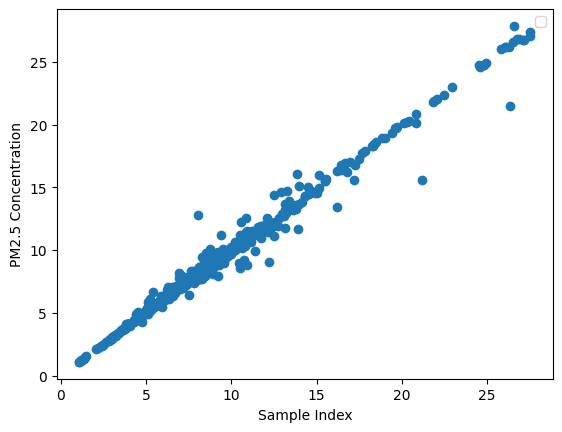

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(y_test, y_pred)
plt.xlabel('Sample Index')
plt.ylabel('PM2.5 Concentration')
plt.legend()

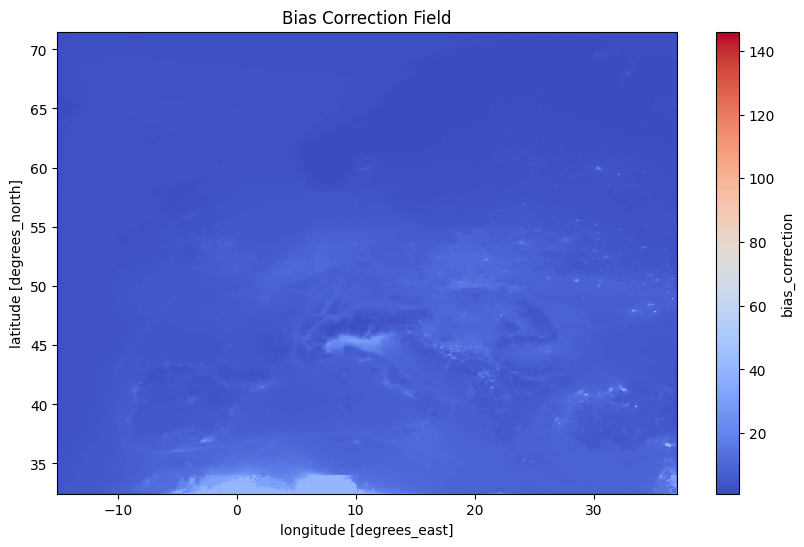

In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.colors as mcolors


if 'bias_correction' in nc_data:
    bias_correction = nc_data['bias_correction']
    plt.figure(figsize=(10, 6))
    bias_correction.plot(cmap='coolwarm')
    plt.title("Bias Correction Field")
    plt.show()

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


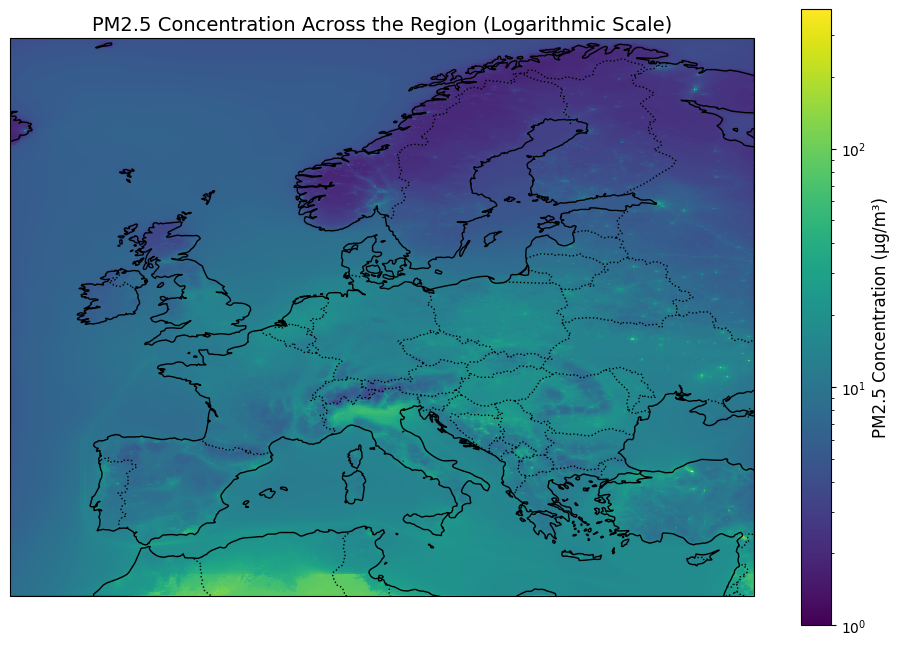

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import xarray as xr

# 1. Φόρτωση δεδομένων από το αρχείο NetCDF
file_path = 'corrected_RandomForestRegressor_PM25.nc'  # Αντικατάστησε με το όνομα του αρχείου σου
nc_data = xr.open_dataset(file_path)

# 2. Εξαγωγή δεδομένων για οπτικοποίηση
lon = nc_data['lon'].values  # Συντεταγμένες μήκους
lat = nc_data['lat'].values  # Συντεταγμένες πλάτους
PM25 = nc_data['corrected_concentration'].isel(time=0).values  # Επιλογή δεδομένων PM2.5

# 3. Δημιουργία πλέγματος (meshgrid) για τις συντεταγμένες
Lon, Lat = np.meshgrid(lon, lat)

# 4. Ορισμός λογαριθμικής κλίμακας
norm = mcolors.LogNorm(vmin=1, vmax=np.nanmax(PM25))  # Λογαριθμική κανονικοποίηση

# 5. Δημιουργία χάρτη με προβολή PlateCarree
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# 6. Οπτικοποίηση των δεδομένων PM2.5 με pcolormesh και λογαριθμική κλίμακα
mesh = ax.pcolormesh(Lon, Lat, PM25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# 7. Προσθήκη γραμμής χρωμάτων (colorbar)
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('PM2.5 Concentration (µg/m³)', fontsize=12)

# 8. Προσθήκη γεωγραφικών χαρακτηριστικών (ακτογραμμές και σύνορα)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# 9. Τίτλος και εμφάνιση του χάρτη
plt.title('PM2.5 Concentration Across the Region (Logarithmic Scale)', fontsize=14)
plt.show()
